In [45]:

import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as spo
from scipy import integrate
import sympy as sym
from itertools import permutations
from itertools import combinations
from itertools import combinations_with_replacement

In [2]:
def f(v):
    return v[0]**2 + v[1]**2 + v[2]**2-2*v[2]+1

constraints = ( {'type':'eq','fun': lambda v: 2*v[0] -4*v[1] +5*v[2]-2} )

v0 = [1,1,1]
result = spo.minimize( f, v0, constraints = constraints )
result

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.20000000000216844
       x: [-1.333e-01  2.667e-01  6.667e-01]
     nit: 4
     jac: [-2.667e-01  5.333e-01 -6.667e-01]
    nfev: 18
    njev: 4

In [3]:
result.fun

0.20000000000216844

# 2

In [62]:
def fun(v):
    return -v[0]*v[1]*v[2]

v0 = [1, 1, 1]

condiciones = [{'type': 'eq', 'fun': lambda v: v[0]*v[1] + 2*v[1]*v[2] + 2*v[0]*v[2]-12}]

result = spo.minimize(fun, v0, method= "SLSQP",constraints=condiciones,options = {"disp":True})
result.fun*-1

Optimization terminated successfully    (Exit mode 0)
            Current function value: -4.000000340488772
            Iterations: 38
            Function evaluations: 190
            Gradient evaluations: 38


4.000000340488772

Por multimplicadores de lagrange tendremos el siguiente sistema de ecuaciones

In [32]:
G = np.array([lambda x,y,z,l: l*(2*y+z)-y*z,
     lambda x,y,z,l: l*(2*z+2*x)-x*z,
     lambda x,y,z,l: l*(2*y+x) - x*y,
     lambda x,y,z,l: 2*x*y + 2*z*y + x*z-12])

def GetF(G,r):
    
    n = r.shape[0]
    
    v = np.zeros_like(r)
    
    for i in range(n):
        v[i] = G[i](r[0],r[1],r[2],r[3])
        
    return v

def GetJacobian(f,r,h=1e-6):
    
    n = r.shape[0]
    
    J = np.zeros((n,n))
    
    for i in range(n):
        for j in range(n):
            
            rf = r.copy()
            rb = r.copy()
            
            rf[j] = rf[j] + h
            rb[j] = rb[j] - h
            
            J[i,j] = ( f[i](rf[0],rf[1],rf[2],rf[3]) - f[i](rb[0],rb[1],rb[2],rb[3])  )/(2*h)
            
    
    return J

def NewtonRaphson(G,r,itmax=1000,error=1e-9):
    
    it = 0
    d = 1.
    dvector = []
    
    while d > error and it < itmax:
        
        # Vector actual
        rc = r
        
        F = GetF(G,rc)
        J = GetJacobian(G,rc)
        InvJ = np.linalg.inv(J)
        
        r = rc - np.dot(InvJ,F)
        
        diff = r - rc
        
        d = np.max( np.abs(diff) )
        
        dvector.append(d)

        
        it += 1
    
    return r,dvector

r,dvector = NewtonRaphson(G,np.array([1,1,1,2]))
r

array([2. , 1. , 2. , 0.5])

# Generales de probabilidad

# 4

La probabilidad de que n personas complan días distintos será:
$$\begin{align*}
\prod_{i= 0}^{n}\frac{(N-i)}{N}
\end{align*}
$$
donde n<N y N será el total de dias, es decir N=365

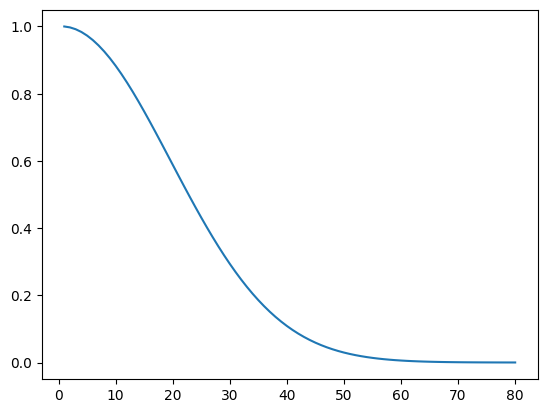

In [5]:
def proba(n,N):
    prob = 1
    for i in range(n):
        prob *= (N-i)/N
    return prob

N = 365
n = 80  
casos = np.arange(n)+1
probabilidad = np.zeros(n)

for i in range(1,n+1):
    probabilidad[i-1]= proba(i,N)

plt.plot(casos,probabilidad)

# 8

In [23]:
monedas = np.array([1,-1,1,-1,1,-1,1,-1])
N = 1e5

valor = 0
for i in range(int(N)):
    np.random.shuffle(monedas)
    elec = monedas[:4]
    if sum(elec) == 0:
        valor += 1

proba = valor/N
proba

0.51357

# Distribuciones continuas de probabilidad

Hidden Markov models

In [63]:
#1

# J= justa
# B= sesgada
dic1= {"B":0, "J":1}
dic2= {"C":1, "S":0}
T= np.array([[0.8,0.2],[0.2,0.8]])
E= np.array([[0.5,0.9], [0.5,0.1]])
obs= [0,1,1,1,0,1,0,1]
prior=(0.2,0.8)

def GetProb1(T,State,Prior):
    
    n = len(State)
    p = 1.
    
    p *= Prior[State[0]]
    
    for i in range(n-1):
        p *= T[ State[i+1], State[i]  ]
        
    return p


def GetProb(T,E,Obs,State,Prior):
    
    n = len(Obs)
    p = 1.
    
    p *= Prior[State[0]]

    for i in range(n-1):
        p *= T[ State[i+1], State[i]  ]
        
    for i in range(n):
        p *= E[ Obs[i], State[i] ]
        
    return p


def GetStates(States,N):
    
    CStates = list( combinations_with_replacement(States,N) )  
    Permu = []
    
    for it in CStates:
        p = list(permutations(it,N)) 
        for i in p:
            if i not in Permu:
                Permu.append(i)
                
    return np.array(Permu)

hiddenstates= GetStates(np.array([0,1]),8)
obsstates= GetStates(np.array([0,1]),8)
probstates=np.zeros(hiddenstates.shape[0], dtype=np.float64)
for i in range(probstates.shape[0]):
    probstates[i] = GetProb1(T,hiddenstates[i],prior)
    
ii = np.where( probstates == np.amax(probstates))
print(hiddenstates[ii])
print(np.amax(probstates))

Nobs = obsstates.shape[0]
PObs = np.zeros(Nobs)

for j in range(Nobs):
    
    dim = hiddenstates.shape[0]
    P = np.zeros(dim)
    
    for i in range(dim):
        P[i] = GetProb(T,E,obsstates[j],hiddenstates[i],prior)
        
    PObs[j] = np.sum(P)
    
print("suma prob")
print(np.sum(PObs))

prob_obs= np.zeros(hiddenstates.shape[0], dtype=np.float64)
for i in range(prob_obs.shape[0]):
    prob_obs[i]= GetProb(T,E,obs,hiddenstates[i],prior)

print("probmax")
print(np.amax(prob_obs))




[[1 1 1 1 1 1 1 1]]
0.1677721600000001
suma prob
1.0000000000000007
probmax
0.00029491200000000015


Distribuciones continuas de probabilidad


In [47]:
x = sym.Symbol('x')
y = sym.Symbol('y')
f = (x + 2*y)*(2/3)

funcion = sym.Piecewise((f, (x >= 0) & (y >= 0) & (x <= 1) & (y <= 1)), (0, True))

probtot= sym.integrate(funcion, (x,0,1),(y, 0, 1))
g=  sym.integrate(funcion,(y, 0, 1))
h= sym.integrate(funcion, (x, 0, 1))
e_x= sym.integrate(x*g, (x, 0, 1))
e_y= sym.integrate(y*h, (y, 0, 1))
cov1= sym.integrate(x*y*funcion, (x, 0, 1),(y, 0, 1))-e_x*e_y

print("PROBABILIDAD TOTAL")
print(probtot)
print("g(x)")
print(g)
print("h(y)")
print(h)
print("E(x)")
print(e_x)
print("E(y)")
print(e_y)
print("Cov1(x,y)")
print(cov1)




PROBABILIDAD TOTAL
1.00000000000000
g(x)
Piecewise((0.666666666666667*x + 0.666666666666667, (x >= 0) & (x <= 1)), (0, True))
h(y)
Piecewise((1.33333333333333*y + 0.333333333333333, (y >= 0) & (y <= 1)), (0, True))
E(x)
0.555555555555556
E(y)
0.611111111111111
Cov1(x,y)
-0.00617283950617281
Cov2(x,y)


MÍNIMOS CUADRADOS

1b

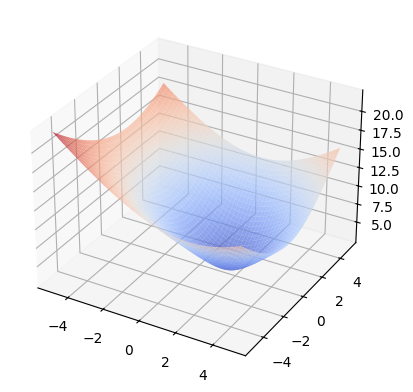

In [64]:
A = np.array([[2., -1.],
              [1., 2.],
              [1., 1.]])
b = np.array([2., 1., 4.])

x = np.linspace(-5, 5, 1000)
y = np.linspace(-5, 5, 1000)
X, Y = np.meshgrid(x, y)
Z = np.zeros_like(X)

for i in range(len(x)):
    for j in range(len(y)):
        lis = np.array([X[i, j], Y[i, j]])
        v = np.linalg.norm(np.dot(A, lis) - b)
        Z[i, j] = v

fig = plt.figure()
ax3d = fig.add_subplot(111, projection='3d')
ax3d.plot_surface(X, Y, Z, cmap='coolwarm', alpha=0.7)

7

In [61]:


u1= np.array([3,1,0,1])
u2= np.array([1,2,1,1])
u3= np.array([-1,0,2,-1])
b=np.array([-3,-3,8,9])
A= np.array([u1.T,u2.T,u3.T])

def ort(A, b):
    x, residuals, _, _ = np.linalg.lstsq(A.T, b, rcond=None)
    proj = np.dot(A.T, x)

    return proj

print("PROYECCION 1")
print(ort(A, b))

def GramSchmidt(u1,u2,u3):

    v1= u1/ np.linalg.norm(u1)
    v2= u2 - np.dot(u2,v1)*v1
    v2= v2/np.linalg.norm(v2)
    v3= u3 - np.dot(u3,v1)*v1 - np.dot(u3,v2)*v2
    v3= v3/np.linalg.norm(v3)
    return v1,v2,v3

v1,v2,v3= GramSchmidt(u1,u2,u3)

projection = np.dot(b, v1) * v1 + np.dot(b, v2) * v2 + np.dot(b, v3) * v3

print("PROJECCIÓN", projection)






PROYECCION 1
[-2.00000000e+00  3.00000000e+00  4.00000000e+00  5.55111512e-16]
Projección [-2.00000000e+00  3.00000000e+00  4.00000000e+00  3.33066907e-16]
